# Forecasting Electricity Consumption with Support Vector Regression

Created by Justin Elszasz. 

This notebook describes the process of training a support vector regression model for predicting electricity consumption based on several weather variables, the hour of the day, and whether the day was a weekend/holiday/work-from-home-day or just a normal weekday.



# Quick notes on support vector machines

Support vector machines are a form of machine learning that can be used for classification or regression.  Put as simply as possible, support vector machines find the optimal to line or plane dividing two groups of data or, in the case of regression, the optimal path that characterizes the trend within a tolerance.  

For classification, the algorithm minimizes the risk of misclassifying the data.  

For regression, the algorithm minimizes the risk that the regression model doesn't capture a data point within some acceptable tolerance.

For more information, Google.  Tons of free information and tutorials out there.  Really solid references for machine learning and pattern classification are ["Pattern Recognition and Machine Learning" by Christopher M. Bishop](http://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738/ref=sr_1_sc_1?ie=UTF8&qid=1452695835&sr=8-1-spell&keywords=pattern+classification+bisohp) and ["Pattern Classification" by Richard Duda et al](http://www.amazon.com/Pattern-Classification-2nd-Computer-Manual/dp/0471703508/ref=sr_1_1?ie=UTF8&qid=1452695806&sr=8-1&keywords=pattern+classification+duda).

![image](other/Support_Vector_Classification.gif)

# Importing some packages and data 

In [1]:
%pylab inline
import pandas as pd # Fantastic for data analysis, especially time series!
import numpy as np # matrix and linear algebra stuff, similar to MATLAB
from matplotlib import pyplot as plt # plotting

Populating the interactive namespace from numpy and matplotlib


[Scikit-learn](http://scikit-learn.org/stable/) is one of the big machine learning packages out there for Python.  They have fantastic documentation, tutorials, and examples on their website.

In [2]:
from sklearn import svm
from sklearn import cross_validation
from sklearn import preprocessing as pre

Random plug for better data visualization here. 

In [52]:
# some nice colors - like Dad always said, it's better to look good than to be good
gray_light = '#d4d4d2'
gray_med = '#737373'
red_orange = '#ff3700'

fontsize = 18

The data I've used in this model are obtained through Baltimore Gas and Electric and Opower from a smart meter installed at my apartment in Baltimore, MD.  The smart meter data are exported from the BGE website and conform to the Green Button standard created by NIST.  

The "USAGE" field gives the number of kilowatt-hours of electricity used in that hour.

In [4]:
elec = pd.read_csv('data/elec_hourly_oldApt_2014-04-30.csv', parse_dates=True, index_col=0)
print 'Start of electricity data: ', min(elec.index)
print 'End of electricity data: ', max(elec.index)
elec.head(3)

Start of electricity data:  2014-01-18 00:00:00
End of electricity data:  2014-04-30 23:00:00


,COST,UNITS,USAGE,timestamp_end
timestamp,,,,
2014-01-18 00:00:00,NaN,kWh,1.13,2014-01-18 00:59:00
2014-01-18 01:00:00,NaN,kWh,0.98,2014-01-18 01:59:00
2014-01-18 02:00:00,NaN,kWh,0.94,2014-01-18 02:59:00


Weather data were culled from Weather Underground's API (in another Python script).

In [5]:
weather = pd.read_csv('data/weather_2015-02-01.csv', parse_dates=True, index_col=0)
print 'Start of weather data: ', min(elec.index)
print 'End of weather data: ', max(elec.index)
weather.head()

Start of weather data:  2014-01-18 00:00:00
End of weather data:  2014-04-30 23:00:00


,hum,precipm,tempm,wspdm,tempF
timestamp,,,,,
2014-01-01 01:00:00,45,NaN,-3.9,5.6,25.0
2014-01-01 02:00:00,43,NaN,-3.9,14.8,25.0
2014-01-01 03:00:00,46,NaN,-4.4,14.8,24.1
2014-01-01 04:00:00,46,NaN,-4.4,14.8,24.1
2014-01-01 05:00:00,48,NaN,-4.4,0.0,24.1


# Pre-processing(!)

### Merge electricity and weather

First we need to **merge** the electricity data and weather data into one dataframe and get rid of extraneous information.

In [91]:
# Merge into one Pandas dataframe
elec_and_weather = pd.merge(weather, elec, left_index=True, right_index=True)

# Remove unnecessary fields from dataframe
del elec_and_weather['tempm'], elec_and_weather['COST'], elec_and_weather['UNITS']
del elec_and_weather['precipm']

# Convert windspeed to MPH for my feeble brain to interpret
elec_and_weather['wspdMPH'] = elec_and_weather['wspdm'] * 0.62
del elec_and_weather['wspdm']

print '\nTotal number of observations: ', len(elec_and_weather),'\n'
elec_and_weather.head()


Total number of observations:  2470 



,hum,tempF,USAGE,timestamp_end,wspdMPH
timestamp,,,,,
2014-01-18 00:00:00,56,39.2,1.13,2014-01-18 00:59:00,4.588
2014-01-18 01:00:00,61,39.2,0.98,2014-01-18 01:59:00,4.588
2014-01-18 02:00:00,61,39.2,0.94,2014-01-18 02:59:00,4.588
2014-01-18 03:00:00,65,39.2,1.11,2014-01-18 03:59:00,4.588
2014-01-18 04:00:00,70,39.2,1.34,2014-01-18 04:59:00,4.588


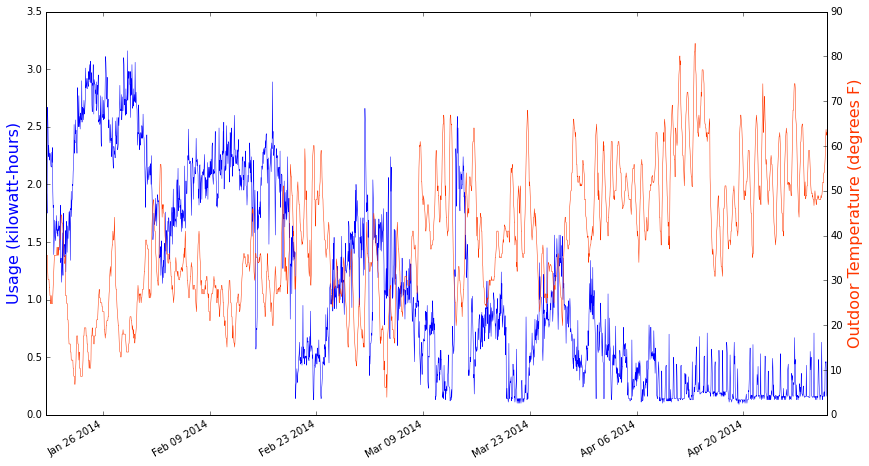

In [89]:
fig = plt.figure(figsize=[14,8])

ax1 = elec_and_weather['USAGE'].plot(label='asdf', color='b', linewidth=0.5)
ax2 = elec_and_weather['tempF'].plot(secondary_y = True, label='cew', color=red_orange, linewidth=0.5)
ax1.set_xlabel('')
ax1.set_ylabel('Usage (kilowatt-hours)', fontsize=fontsize, color = 'b')
ax2.set_ylabel('Outdoor Temperature (degrees F)', fontsize=fontsize, color=red_orange)
ax1.grid('off')

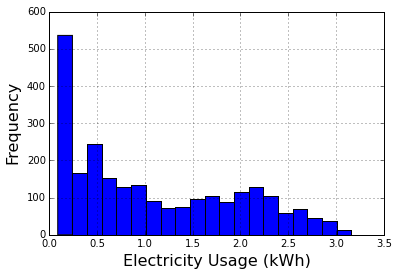

In [84]:
elec_and_weather['USAGE'].hist(bins=20)
xlabel('Electricity Usage (kWh)', fontsize=fontsize)
ylabel('Frequency', fontsize=fontsize)

I want to distinguish typical weekdays from any weekends, holidays and days I worked from home.  I don't think any of those categories have enough of their own examples in order to qualify them as their own set so for now all normal weekdays are 0, all holidays, weekends, and work-from-home days are 1's.  

### Categorical variable: weekdays v. weekends/holidays/working-from-home

In [92]:
## Set weekends and holidays to 1, otherwise 0
elec_and_weather['Atypical_Day'] = np.zeros(len(elec_and_weather['USAGE']))

# Weekends
elec_and_weather['Atypical_Day'][(elec_and_weather.index.dayofweek==5)|(elec_and_weather.index.dayofweek==6)] = 1

# Holidays, days I worked from home
holidays = ['2014-01-01','2014-01-20']
work_from_home = ['2014-01-21','2014-02-13','2014-03-03','2014-04-04']

for i in range(len(holidays)):
    elec_and_weather['Atypical_Day'][elec_and_weather.index.date==np.datetime64(holidays[i])] = 1

for i in range(len(work_from_home)):
    elec_and_weather['Atypical_Day'][elec_and_weather.index.date==np.datetime64(work_from_home[i])] = 1
 
elec_and_weather.head(3)

C:\Users\jelszasz\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jelszasz\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jelszasz\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,hum,tempF,USAGE,timestamp_end,wspdMPH,Atypical_Day
timestamp,,,,,,
2014-01-18 00:00:00,56,39.2,1.13,2014-01-18 00:59:00,4.588,1
2014-01-18 01:00:00,61,39.2,0.98,2014-01-18 01:59:00,4.588,1
2014-01-18 02:00:00,61,39.2,0.94,2014-01-18 02:59:00,4.588,1


### More categorical variables: day of week, hour

For this case each hour of the day is a categorical variable, not continuous. The doing the analysis will require "yes" or "no" corresponding to each hour of the day.

In [8]:
# Create new column for each hour of day, assign 1 if index.hour is corresponding hour of column, 0 otherwise

for i in range(0,24):
    elec_and_weather[i] = np.zeros(len(elec_and_weather['USAGE']))
    elec_and_weather[i][elec_and_weather.index.hour==i] = 1
    
# Example 3am
elec_and_weather[3][:6]

C:\Users\jelszasz\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


timestamp
2014-01-18 00:00:00    0
2014-01-18 01:00:00    0
2014-01-18 02:00:00    0
2014-01-18 03:00:00    1
2014-01-18 04:00:00    0
2014-01-18 05:00:00    0
Name: 3, dtype: float64

### Time-series: need to append with historical window of previous electricity demand

Since this is a time series, if we want to predict the next hour's energy consumption, any given X vector/Y target pair in the training data should provide the current hour's electricity use (Y value, or target) with the previous hour's (or however many past hours are used) weather data and usage (X vector).

In [9]:
# Add historic usage to each X vector

# Set number of hours prediction is in advance
n_hours_advance = 1

# Set number of historic hours used
n_hours_window = 12


for k in range(n_hours_advance,n_hours_advance+n_hours_window):
    
    elec_and_weather['USAGE_t-%i'% k] = np.zeros(len(elec_and_weather['USAGE']))
    #elec_and_weather['tempF_t-%i'% k] = np.zeros(len(elec_and_weather['tempF']))
    #elec_and_weather['hum_t-%i'% k] = np.zeros(len(elec_and_weather['hum']))
    #elec_and_weather['wspdMPH_t-%i'% k] = np.zeros(len(elec_and_weather['wspdMPH']))
    
    
for i in range(n_hours_advance+n_hours_window,len(elec_and_weather['USAGE'])):
    
    for j in range(n_hours_advance,n_hours_advance+n_hours_window):
        
        elec_and_weather['USAGE_t-%i'% j][i] = elec_and_weather['USAGE'][i-j]
        #elec_and_weather['tempF_t-%i'% j][i] = elec_and_weather['tempF'][i-j]
        #elec_and_weather['wspdMPH_t-%i'% j][i] = elec_and_weather['wspdMPH'][i-j]
        #elec_and_weather['hum_t-%i'% j][i] = elec_and_weather['hum'][i-j]

elec_and_weather = elec_and_weather.ix[n_hours_advance+n_hours_window:]
        
elec_and_weather.head(3)


Wall time: 0 ns


C:\Users\jelszasz\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,hum,tempF,USAGE,timestamp_end,wspdMPH,Atypical_Day,0,1,2,3,...,USAGE_t-3,USAGE_t-4,USAGE_t-5,USAGE_t-6,USAGE_t-7,USAGE_t-8,USAGE_t-9,USAGE_t-10,USAGE_t-11,USAGE_t-12
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-01-18 13:00:00,75,37.4,1.60,2014-01-18 13:59:00,4.588,1,0,0,0,0,...,1.54,1.56,1.44,1.26,1.33,1.16,1.34,1.11,0.94,0.98
2014-01-18 14:00:00,75,37.4,1.68,2014-01-18 14:59:00,4.588,1,0,0,0,0,...,1.87,1.54,1.56,1.44,1.26,1.33,1.16,1.34,1.11,0.94
2014-01-18 15:00:00,60,37.4,1.43,2014-01-18 15:59:00,4.588,1,0,0,0,0,...,1.88,1.87,1.54,1.56,1.44,1.26,1.33,1.16,1.34,1.11


### Breaking into training and testing periods

Since this is time series data, it makes more sense to define training and testing periods, rather than random sporadic data points.  If it weren't a time series, we could select a random sample to segregate for a testing set.  

In [10]:
# Define training and testing periods
train_start = '18-jan-2014'
train_end = '24-march-2014'
test_start = '25-march-2014'
test_end = '31-march-2014'

In [11]:
# Split up into training and testing sets (still in Pandas dataframes)

X_train_df = elec_and_weather[train_start:train_end]
del X_train_df['USAGE']
del X_train_df['timestamp_end']
#del X_train_df['hum']
#del X_train_df['tempF']
del X_train_df['wspdMPH']

y_train_df = elec_and_weather['USAGE'][train_start:train_end]

X_test_df = elec_and_weather[test_start:test_end]
del X_test_df['USAGE']
del X_test_df['timestamp_end']
#del X_test_df['hum']
#del X_test_df['tempF']
del X_test_df['wspdMPH']

y_test_df = elec_and_weather['USAGE'][test_start:test_end]

Printed out the training set to a csv in case anyone wants to take a better look.

In [12]:
X_train_df.to_csv('output/training_set.csv')

In [13]:
N_train = len(X_train_df[0])
print 'Number of observations in the training set: ', N_train

Number of observations in the training set:  1569


The scikit-learn package takes in Numpy arrays, not Pandas DataFrames, so we need to convert.

In [14]:
# Numpy arrays for sklearn
X_train = np.array(X_train_df)
X_test = np.array(X_test_df)
y_train = np.array(y_train_df)
y_test = np.array(y_test_df)

### Scaling variables

All variables need scaled.  The algorithm doesn't know anything about what scales each of the variables are on.  In other words, a value of 73 in the temperature column would look like it dominates over a 0.3 in the previous hour kWh usage since the actual values are so different.  StandardScaler() from the preprocessing module in sklearn removes the mean from each variable and scales to unit variance.  When the model is trained on the scaled data the model does the job of determining which variables are more influential rather than the arbitrary scale/order of magnitude predetermining that influence.

In [15]:
from sklearn import preprocessing as pre
scaler = pre.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the SVR model

Fit the model to the training data!

In [16]:
SVR_model = svm.SVR(kernel='rbf',C=100,gamma=.001).fit(X_train_scaled,y_train)
print 'Testing R^2 =', round(SVR_model.score(X_test_scaled,y_test),3)

Testing R^2 = 0.788


# Prediction and testing

Calculate next-hour forecast (predict!)  We set aside a test dataset, so we'll use all the input variables (scaled appropriately) to predict the "Y" target values (the usage at the next hour).

In [17]:
# Use SVR model to calculate predicted next-hour usage
predict_y_array = SVR_model.predict(X_test_scaled)

# Put it in a Pandas dataframe for ease of use
predict_y = pd.DataFrame(predict_y_array,columns=['USAGE'])
predict_y.index = X_test_df.index

Plot time series of actual and predicted electricity demand over the testing period.

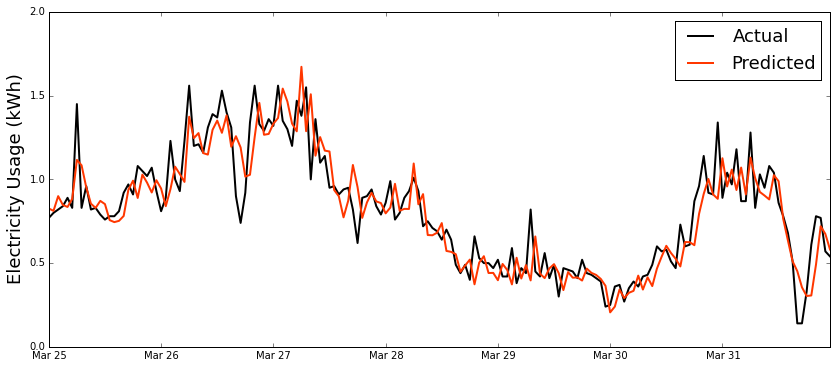

In [75]:
# Plot the predicted values and actual
import matplotlib.dates as dates

plot_start = test_start
plot_end = test_end

fig = plt.figure(figsize=[14,6])
ax = fig.add_subplot(111)
plt.plot(y_test_df.index,y_test_df,color='k',linewidth=2)
plt.plot(predict_y.index,predict_y,color=red_orange,linewidth=2)
plt.ylabel('Electricity Usage (kWh)', fontsize=fontsize)
plt.ylim([0,2])
plt.legend(['Actual','Predicted'],loc='best', fontsize=fontsize)
ax.xaxis.set_major_formatter(dates.DateFormatter('%b %d'))
#fig.savefig('SVM_predict_TS.png')

### Resampled results to daily kilowatt-hours

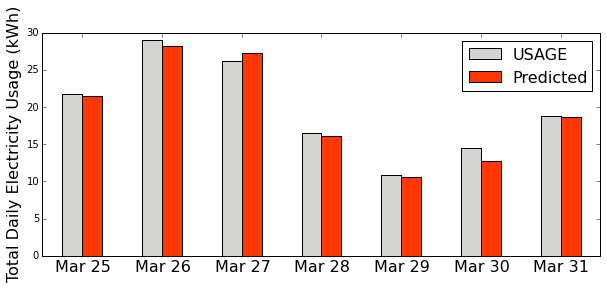

In [103]:
### Plot daily total kWh over testing period
y_test_barplot_df = pd.DataFrame(y_test_df,columns=['USAGE'])
y_test_barplot_df['Predicted'] = predict_y['USAGE']

fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)
y_test_barplot_df.resample('d',how='sum').plot(kind='bar',ax=ax,color=[gray_light,red_orange])
ax.grid(False)
ax.set_ylabel('Total Daily Electricity Usage (kWh)', fontsize=fontsize)
ax.set_xlabel('')
# Pandas/Matplotlib bar graphs convert xaxis to floats, so need a hack to get datetimes back
ax.set_xticklabels([dt.strftime('%b %d') for dt in y_test_df.resample('d',how='sum').index.to_pydatetime()],rotation=0, fontsize=fontsize)
legend(fontsize=fontsize)
plt.show()

#fig.savefig('SVM_predict_DailyTotal.png')


### Error measurements

The following are some accuracy measures.  These are moved to the file errors.py for reuse across other models.

In [101]:
N_test = len(y_test_df)

MBE = errors.calc_MBE(predict_y, y_test_df)
RMSE = errors.calc_RMSE(predict_y, y_test_df)
MAPE = errors.calc_MAPE(predict_y, y_test_df)
CV = errors.calc_CV(predict_y, y_test_df)

print '\nNumber of observations (hours) in test dataset: ', N_test, '\n'
print 'MBE =', round(MBE, 2)
print 'RMSE =', round(RMSE, 2)
print 'MAPE =', round(MAPE, 2)
print 'CV =', round(CV, 2)


Number of observations (hours) in test dataset:  168 

MBE = 0.02
RMSE = 0.15
MAPE = 0.16
CV = 0.19


Plot actual vs. prediced usage.  If prediction were perfect, all points would be on 45 degree line (y=x).


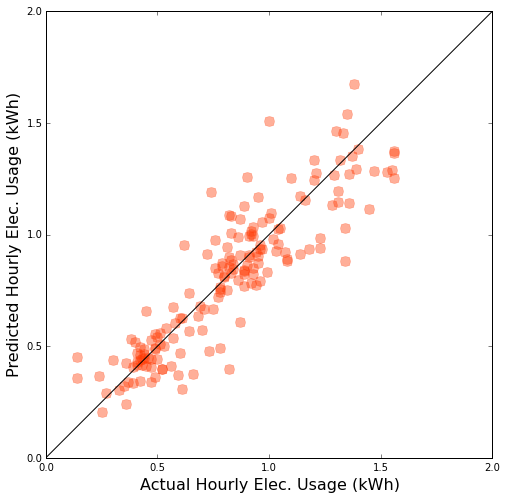

In [102]:
fig = plt.figure(figsize=(8,8))
fontsize = 16
plot = plt.plot(y_test_df,predict_y,color=red_orange,marker='.',linewidth=0,markersize=20,alpha=.4)
plot45 = plt.plot([0,2],[0,2],'k')
plt.xlim([0,2])
plt.ylim([0,2])
plt.xlabel('Actual Hourly Elec. Usage (kWh)', fontsize=fontsize)
plt.ylabel('Predicted Hourly Elec. Usage (kWh)', fontsize=fontsize)

#fig.savefig('SVM_plot_errors.png')

# Not covered in this notebook

* Stationary v. non-stationary
* Overfitting, crossvalidation.
* My new(er) apartment!  (Much more data, been there about 1 year and 8 months)